In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import os

import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import  roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Procesamiento 
#variable de interes
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# Se combina el título de la película con la trama
dataTraining_2 = dataTraining.copy()
dataTraining_2['title_plot'] = dataTraining_2['title'] + ' - ' + dataTraining_2['plot']
dataTraining_2.drop(columns=['title','plot','rating'], inplace=True)

In [5]:
#Encoder
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import seaborn as sns

# Importación el módulo TF Hub del Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)

# Codificación de las frases anteriormente definidas con la libreria tensorflow
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    sentences_embeddings = session.run(embed(dataTraining_2['title_plot']))

#df con encoder y el indice de fila
x_embed = pd.DataFrame(sentences_embeddings)
x_embed.index = dataTraining_2.index

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
# PostProcesamiento
#Se adiciona el año de la película a la matriz de embedding
dataTraining_3 = pd.concat([dataTraining_2, x_embed], axis=1)
dataTraining_3.drop(columns=['title_plot', 'genres'], inplace=True)

# Se estandariza la data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataTraining_3 = scaler.fit_transform(dataTraining_3)

In [7]:
# Se separa la data en conjunto de entrenamiento y conjunto de validación
X_train, X_test, y_train_genres, y_test_genres = train_test_split(dataTraining_3, y_genres, test_size=0.33, random_state=42)

In [8]:
# Importación de librerías para la implementación de la red neuronal

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
%matplotlib inline

dims = dataTraining_3.shape[1]
var_out = y_genres.shape[1]

K.clear_session()
model = Sequential()  
model.add(Dense(512, input_shape=(dims,), activation='sigmoid'))
model.add(Dense(var_out, activation='sigmoid'))

# Definición de función de perdida con parámetros definidos en la función nn_model_params
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

# Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
early_stopping = EarlyStopping(monitor="val_loss", patience = 10)

# Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
model.fit(X_train, y_train_genres, 
          validation_data = (X_test, y_test_genres),
          epochs=6,
          batch_size=64,
          callbacks=[early_stopping],
          verbose=0 
          )

In [10]:
import joblib
# Exportar modelo a archivo binario .pkl
joblib.dump(scaler, 'scaler.pkl', compress=3)

['scaler.pkl']

In [12]:
# serializar el modelo a JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serializar los pesos a HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")

Modelo Guardado!


In [14]:
from keras.models import model_from_json
# cargar json y crear el modelo
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# cargar pesos al nuevo modelo
loaded_model.load_weights("model.h5")
print("Cargado modelo desde disco.")


Cargado modelo desde disco.


In [15]:
from tensorflow.keras.models import load_model

# evaluate loaded model on test data
loaded_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])


In [16]:
# Predicción del modelo de clasificación
y_pred_genres = loaded_model.predict(X_test)


In [17]:

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8995432047436122

In [18]:
from proy_final.proyecto_deployment import transformar

ModuleNotFoundError: No module named 'proy_final'

In [19]:
df_datos = pd.DataFrame({'year': 1999, 'title': 'Message in a Bottle', 'plot': "who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can ' t let go of their past ."
                        }, index=[0])
df_datos

a = transformar(df_datos)
a

NameError: name 'transformar' is not defined

### Tratamiento para nuevos datos

In [20]:
# Para predecir en la base de datos de test de kaggle hay que hacer el mismo tratamiento:

dataTesting_2 = dataTesting.copy()
dataTesting_2['title_plot'] = dataTesting_2['title'] + ' - ' + dataTesting_2['plot']
dataTesting_2.drop(columns=['title','plot'], inplace=True)

tf.disable_eager_execution()

# Importación el módulo TF Hub del Universal Sentence Encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)

# Codificación de las frases anteriormente definidas con la libreria tensorflow
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    sentences_embeddings_2 = session.run(embed(dataTesting_2['title_plot']))

x_test_embed = pd.DataFrame(sentences_embeddings_2)
x_test_embed.index = dataTesting_2.index

dataTesting_3 = pd.concat([dataTesting_2, x_test_embed], axis=1)
dataTesting_3.drop(columns=['title_plot'], inplace=True)
dataTesting_3 = scaler.transform(dataTesting_3)
dataTesting_3

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


array([[ 0.40926234, -1.47839968,  1.27092404, ..., -1.12714377,
        -0.77246394, -0.49437369],
       [-0.51751018,  1.51811802, -1.53552941, ..., -0.36326047,
        -1.69964995, -0.76843429],
       [ 0.27686627,  0.86066068, -0.98737598, ..., -1.07936252,
         1.78576654, -0.84550072],
       ...,
       [-1.44428269,  0.60256332,  1.55663727, ...,  0.35145835,
        -1.24557518,  1.26552321],
       [ 0.54165841, -1.17895458,  0.52006313, ...,  0.69264894,
        -0.63741888,  0.65110491],
       [ 0.14447019,  1.27188799, -0.68939945, ...,  2.78668321,
        -0.28234931,  0.99353229]])

### Predicción nuevos datos

In [21]:
y_pred_genres_2 = model.predict(dataTesting_3)

In [22]:
# Guardar predicciones en formato exigido en la competencia de kaggle

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_genres_2, index=dataTesting.index, columns=cols)
res.to_csv('pred_calib_param_3.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.007127,0.014335,0.007080,0.007005,0.125303,0.017361,0.000572,0.936827,0.012359,0.030298,...,0.040527,0.337028,0.000604,0.623894,0.001954,0.007956,0.000887,0.092559,0.003472,0.012351
4,0.122924,0.010790,0.000545,0.083440,0.688476,0.807832,0.006762,0.810451,0.001459,0.001090,...,0.003098,0.030709,0.000788,0.050847,0.001228,0.006004,0.000423,0.349205,0.038890,0.000777
5,0.047408,0.007027,0.000103,0.075686,0.023864,0.832706,0.008022,0.903097,0.000459,0.006176,...,0.000171,0.520159,0.000436,0.074660,0.001437,0.000295,0.005596,0.725579,0.002887,0.002973
6,0.083226,0.061168,0.000757,0.025339,0.087315,0.021179,0.002249,0.879757,0.001639,0.005621,...,0.001285,0.089138,0.000899,0.142520,0.125919,0.001196,0.002087,0.320816,0.438775,0.005902
7,0.072787,0.028169,0.003103,0.019340,0.044356,0.121155,0.002893,0.233455,0.014237,0.286801,...,0.009425,0.463553,0.000794,0.024760,0.466445,0.002192,0.000991,0.762882,0.001760,0.002981


### API

In [23]:
model

In [ ]:
# Nota: lo entreno otra vez uno diferente, para validar que la infraestructura del anterior no incide en el problema de guardado

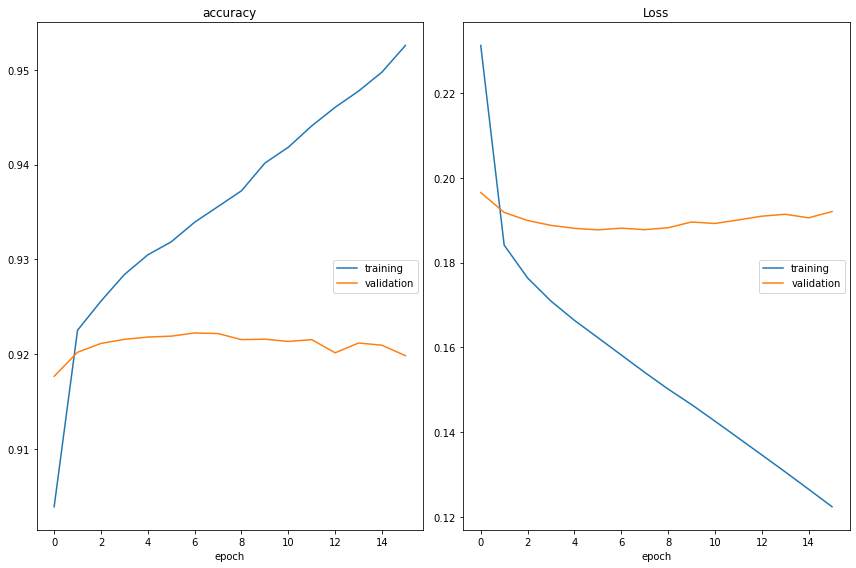

accuracy
	training         	 (min:    0.904, max:    0.953, cur:    0.953)
	validation       	 (min:    0.918, max:    0.922, cur:    0.920)
Loss
	training         	 (min:    0.122, max:    0.231, cur:    0.122)
	validation       	 (min:    0.188, max:    0.197, cur:    0.192)
5289/5289 [==============================] - 1s 107us/sample - loss: 0.1224 - accuracy: 0.9526 - val_loss: 0.1920 - val_accuracy: 0.9198


In [24]:
K.clear_session()

# Definición red neuronal con la función Sequential()
model2 = Sequential()
    
# Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
model2.add(Dense(512, input_shape=(dims,), activation='sigmoid'))
model2.add(Dense(var_out, activation='sigmoid'))

# Definición de función de perdida con parámetros definidos en la función nn_model_params
model2.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ['accuracy'])

# Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
early_stopping = EarlyStopping(monitor="val_loss", patience = 10)

# Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
model2.fit(X_train, y_train_genres,
          validation_data = (X_test, y_test_genres),
          epochs=20,
          batch_size=64,
          callbacks=[early_stopping, PlotLossesKeras()],
          verbose=True
          )

In [25]:
import joblib
import tensorflow as tf

# guardar el modelo
#joblib.dump(model, 'API/modelo_red_neuronal.pkl', compress=3)
joblib.dump(scaler, 'model_deploy/scaler.pkl', compress=3)

#tf.saved_model.save(model, 'API/modelo_red_neuronal3')

model2.save('model_deploy/modelo_red_neuronal_h5.h5')

FileNotFoundError: [Errno 2] No such file or directory: 'model_deploy/scaler.pkl'

In [26]:
from tensorflow.keras.models import load_model

modelo_cargado = load_model('API/modelo_red_neuronal_h5.h5')

OSError: SavedModel file does not exist at: API/modelo_red_neuronal_h5.h5\{saved_model.pbtxt|saved_model.pb}

In [ ]:
modelo_cargado.predict(X_test)

In [ ]:
import pandas as pd

In [ ]:
dataTesting.loc[1]['plot']

In [ ]:
df_datos = pd.DataFrame({'year': 1999, 'title': 'Message in a Bottle', 'plot': "who meets by fate ,  shall be sealed by fate .  theresa osborne is running along the beach when she stumbles upon a bottle washed up on the shore .  inside is a message ,  reading the letter she feels so moved and yet she felt as if she has violated someone ' s thoughts .  in love with a man she has never met ,  theresa tracks down the author of the letter to a small town in wilmington ,  two lovers with crossed paths .  but yet one can ' t let go of their past ."
                        }, index=[0])
df_datos

In [ ]:
from API.proyecto2_deployment import transformar

In [ ]:
a = transformar(df_datos)
a

In [27]:
from flask import Flask
from flask_restx import Api, Resource, fields

In [28]:

app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Clasificación de género de películas',
    description='Clasificación de género de películas')

ns = api.namespace('predict', 
     description='Predicción géneros de la película')

parser = api.parser()

parser.add_argument(
    'year', 
    type=int, 
    required=True, 
    help='Año del lanzamiento de la película', 
    location='args')

parser.add_argument(
    'title', 
    type=str, 
    required=True, 
    help='Nombre de la película', 
    location='args')

parser.add_argument(
    'plot', 
    type=str, 
    required=True, 
    help='Trama de la película', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [29]:
@ns.route('/')
class PrediccionApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": transformar(args)  
        }, 200

In [30]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=8888)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


INFO:werkzeug: * Running on http://192.168.0.9:8888/ (Press CTRL+C to quit)
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swaggerui/droid-sans.css HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swaggerui/swagger-ui.css HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swagger.json HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:07] "GET /swaggerui/favicon-32x32.png HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.9 - - [28/May/2022 09:50:51] "GET /predict/?year=2000&title=dog&plot=happy%20babies%20in%20the%20love%20of%20mountain HTTP/1.1" 500 -
Traceback (most recent call last):
  File "C:\Users\ivanb\anaconda3\Lib\site

In [31]:
!pip freeze '/requirem.txt'

absl-py @ file:///opt/conda/conda-bld/absl-py_1639803114343/work
aiohttp @ file:///C:/ci/aiohttp_1646806572557/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.2.0
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
aniso8601 @ file:///tmp/build/80754af9/aniso8601_1614708839015/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astor==0.8.1
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1650634291321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout @ file:///t